<img src="../assets/header.gif"
     width="4000" 
     height="100"/>
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2.5vw; color:#c6cde1; font-weight:bold;">
    Bilevel formulation: ISGT notebook
    </b>
</p>
<hr style="color:#c6cde1;">
<b>Description</b><br>
<p align="justify">
    The purpose of this notebook is to run several simulations for the ISGT paper
<br><br>
<b>Author</b><br><br> 
<i>Manon Cornet</i>

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    1. Initialization
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Initialize all the librairies needed for the project;</li>
        <li style="margin-bottom:10px">Include the code containing the bilevel formulation</li>
    </ul> 

In [14]:
# -- IMPORTATION OF THE PACKAGES --

import DataFrames, XLSX
using JuMP, BilevelJuMP, Gurobi
using Plots, Graphs, GraphRecipes
using Printf, Dates, LaTeXStrings

In [15]:
# -- IMPORTATION OF THE BUILDING PROFILE AND EXPORT FILES --

include("../upper_level_manon/building_profiles.jl")
include("../upper_level_manon/post_process.jl")

add_var_to_XLSX (generic function with 1 method)

In [16]:
# -- FUNCTION TO PRINT TITLE --

function print_title(title::String)
    println(title)
    for i in 1:length(title) @printf("-") end
    @printf("\n")
end

print_title (generic function with 1 method)

In [17]:
# -- FUNCTION TO PRINT 1D ARRAY --

function print_vector(vector::Vector{<:Number}, units)
    println("["*join(vector, ", ")*"] [$units]")
end

print_vector (generic function with 1 method)

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    2. Upper-level parameters 
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Load a network model from an Excel file and initialize the parameters of the network;</li>
        <li style="margin-bottom:10px">Define the objective function parameters of the Upper-level</li>
    </ul> 

[comment]: <> (Subsection)
<p align="left">
    <b style="font-size:1.5vw; color:#c6cde1;">
    2.1 Network model
    </b>
</p>
<hr style="color:#c6cde1;">

In [18]:
# -- LOADING THE EXCEL FILE CONTAINING THE NETWORK TOPOLOGY --

XLSX_FILE_PATH = joinpath(splitdir(@__DIR__)[1], "network_models/network_Nahman_Peric_2S23H.xlsx")

"/Users/manoncornet/Documents/University/TFE/DNEP/network_models/network_Nahman_Peric_2S23H.xlsx"

In [19]:
# -- DEFINITION OF THE PER UNIT BASIS --
# Values obtained by reading the Paper "A Constructive Heuristic Algorithm for Distribution System Planning"

const BASE_VOLTAGE    = 34.5                             # [kV]
const BASE_POWER      = 1                                # [MVA]
const BASE_CURRENT    = BASE_POWER / BASE_VOLTAGE        # [kA]
const BASE_ADMITTANCE = BASE_CURRENT / BASE_VOLTAGE      # [S]
const BASE_IMPEDANCE  = 1/BASE_ADMITTANCE                # [Ohm]
print_title("Per-unit basis:")

@printf("Base Admittance : %.3e [S]\n", BASE_ADMITTANCE)
@printf("Base Impedance  : %.3e [Ohm]\n", BASE_IMPEDANCE)
@printf("Base Voltage    : %.3e [kV]\n", BASE_VOLTAGE)
@printf("Base Current    : %.3e [kA]\n", BASE_CURRENT)
@printf("Base Power      : %.3e [MVA]\n", BASE_POWER)

Per-unit basis:
---------------
Base Admittance : 8.402e-04 [S]
Base Impedance  : 1.190e+03 [Ohm]
Base Voltage    : 3.450e+01 [kV]
Base Current    : 2.899e-02 [kA]
Base Power      : 1.000e+00 [MVA]


In [20]:
# -- FUNCTION THAT PROCESSES THE LINE PROPRETIES  --

function process_conductors(df_cond::DataFrames.DataFrame, 
                            len_lines::Vector{Float64},  
                            nb_lines::Integer, 
                        )

    nb_cond = DataFrames.nrow(df_cond)
    max_i   = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    r       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    x       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    g       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    b       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    
    line_cost = Array{Float64}(undef, nb_lines, nb_cond) # [€/km]

    # Only take the first conductors of the list in the file
    for l in 1:nb_lines
        for k in 1:nb_cond
            max_i[l, k] = df_cond.max_i_ka[k] ./ BASE_CURRENT

            r[l, k] = len_lines[l] * df_cond.r_ohm_per_km[k] ./ BASE_IMPEDANCE
            x[l, k] = len_lines[l] * df_cond.x_ohm_per_km[k] ./ BASE_IMPEDANCE
            y = 1/(r[l, k]+im*x[l, k])

            g[l, k] = real(y) 
            b[l, k] = abs(imag(y))

            line_cost[l, k] = df_cond.cost_kdollars_per_km[k] * len_lines[l]
        end
    end
    return max_i, line_cost, r, x, g, b
end

process_conductors (generic function with 1 method)

In [21]:
# -- FETCH THE DATA FROM THE EXCEL SHEET --

df_bus  = DataFrames.DataFrame(XLSX.readtable(XLSX_FILE_PATH, "bus"))
df_line = DataFrames.DataFrame(XLSX.readtable(XLSX_FILE_PATH, "line"))
df_cond = DataFrames.DataFrame(XLSX.readtable(XLSX_FILE_PATH, "conductor"))

Row,idx,Name,d_mm,q_mm2,r_ohm_per_km,x_ohm_per_km,max_i_ka,cost_kdollars_per_km
,Any,Any,Any,Any,Any,Any,Any,Any
1,1,AAC (1/0),9.35,1,0.5502,0.429,0.23,10
2,2,AAC (4/0),13.26,107.3,0.2747,0.402,0.34,20


In [22]:
# -- LINE PARAMETERS DEFINITION --

L_size = DataFrames.nrow(df_line)                                   # Number of lines in the network
L      = 1:L_size                                                   # Line set
line_ends = [(df_line.from_bus[l], df_line.to_bus[l]) for l in L]   # Indices of the line extremities
len_lines = convert(Vector{Float64}, df_line.length_km)             # Line lengths [km]

print_title("Network lines summary:")
@printf("Number of lines : %d\n", L_size)

Network lines summary:
----------------------
Number of lines : 34


In [23]:
# -- DEFINITION OF THE PHYSICAL QUANTITIES ASSOCIATED TO NETWORK LINES --

K_size = DataFrames.nrow(df_cond)   # Number of conductor types
K      = 1:K_size                   # Set of conductors

max_i, line_cost, R, X, G, B, = process_conductors(df_cond, len_lines, L_size)

print_title("Conductor properties:")
println(df_cond)

Conductor properties:
---------------------
2×8 DataFrame
 Row │ idx  Name       d_mm   q_mm2  r_ohm_per_km  x_ohm_per_km  max_i_ka  cost_kdollars_per_km 
     │ Any  Any        Any    Any    Any           Any           Any       Any                  
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │ 1    AAC (1/0)  9.35   1      0.5502        0.429         0.23      10
   2 │ 2    AAC (4/0)  13.26  107.3  0.2747        0.402         0.34      20


In [24]:
# -- BUS PARAMETERS DEFINITION --

N_size = DataFrames.nrow(df_bus)            # Number of buses in the network
N      = 1:N_size                           # Buses set

Ns_size = sum(df_bus.type .== "substation") # Number of substation buses
Ns_init_size = sum(df_bus.S_G_init_mva .> 0)
Nu_size = sum(df_bus.type .== "user")       # Number of load nodes

Ns = 1:Ns_size                              # Set of substation buses
Nu = (1:Nu_size) .+ Ns_size                 # Set of load buses
Ns_init = 1:Ns_init_size
Ns_notinit = setdiff(Ns, Ns_init)

print_title("Network buses summary:")
@printf("Number of buses                            : %d\n", N_size)
@printf("Number of load buses                       : %d\n", Nu_size)
@printf("Number of substation buses                 : %d\n", Ns_size)
@printf("Number of existing substations             : %d\n", Ns_init_size)
@printf("Number of potential additional substations : %d\n", length(Ns_notinit))

Network buses summary:
----------------------
Number of buses                            : 23
Number of load buses                       : 21
Number of substation buses                 : 2
Number of existing substations             : 1
Number of potential additional substations : 1


In [25]:
# -- DEFINITION OF THE PHYSICAL QUANTITIES ASSOCIATED TO NETWORK BUSES --

# Limits on voltage
MIN_VOLTAGE = 0.97  # [pu]
MAX_VOLTAGE = 1.03  # [pu]

print_title("Network buses additional info:")
@printf("Voltage range : [%1.3g, %1.3g] [pu]", MIN_VOLTAGE, MAX_VOLTAGE)

Network buses additional info:
------------------------------
Voltage range : [0.97, 1.03] [pu]

In [26]:
# -- SUBSTATION PARAMETERS DEFINITION --

S_rating_init    = convert(Vector{Float64}, df_bus.S_G_init_mva[Ns]) ./ BASE_POWER # [pu]
S_rating_max     = convert(Vector{Float64}, df_bus.S_G_max_mva[Ns]) ./ BASE_POWER  # [pu]
sub_install_cost = 1e3      # k$
sub_op_cost      = 0.1*1e-3 # k$/kVah^2

print_title("Substation buses additional info:")
print("Initial rating of substations: "); print_vector(S_rating_init, "pu");
print("Maximum rating of substations: "); print_vector(S_rating_max, "pu");
@printf("Substation construction cost : %.3g [k€]\n", sub_install_cost)
@printf("Substation operation cost    : %.3g [k€/kVA^2]", sub_op_cost)

Substation buses additional info:
---------------------------------
Initial rating of substations: [4.0, 0.0] [pu]
Maximum rating of substations: [4.0, 4.0] [pu]
Substation construction cost : 1e+03 [k€]
Substation operation cost    : 0.0001 [k€/kVA^2]

In [27]:
# -- LINK BTW LINES AND NODES --

Omega_sending   = Dict(n => [] for n in N)
Omega_receiving = Dict(n => [] for n in N)
for l in L
    push!(Omega_sending[line_ends[l][1]], l)
    push!(Omega_receiving[line_ends[l][2]], l)
end

print_title("Link btw lines and nodes:")
println("Omega sending  : $Omega_sending")
println("Omega receiving: $Omega_receiving")

Link btw lines and nodes:
-------------------------
Omega sending  : Dict{Int64, Vector{Any}}(5 => [21, 22], 16 => [], 20 => [], 12 => [18], 8 => [28, 29, 30, 33], 17 => [17], 1 => [1], 19 => [5, 6, 7], 22 => [8, 9], 23 => [19, 20], 6 => [25, 26], 11 => [10, 11], 9 => [32], 14 => [24], 3 => [34], 7 => [27], 4 => [23, 31], 13 => [12], 15 => [13, 14, 15], 2 => [], 10 => [2, 3, 4], 18 => [16], 21 => [])
Omega receiving: Dict{Int64, Vector{Any}}(5 => [20], 16 => [8, 25, 34], 20 => [2, 5], 12 => [15], 8 => [27], 17 => [16], 1 => [], 19 => [4], 22 => [7], 23 => [18], 6 => [23, 24], 11 => [9], 9 => [29, 31], 14 => [3, 17, 19, 21], 3 => [32, 33], 7 => [26], 4 => [22, 30], 13 => [11], 15 => [12], 2 => [28], 10 => [1], 18 => [14], 21 => [6, 10, 13])


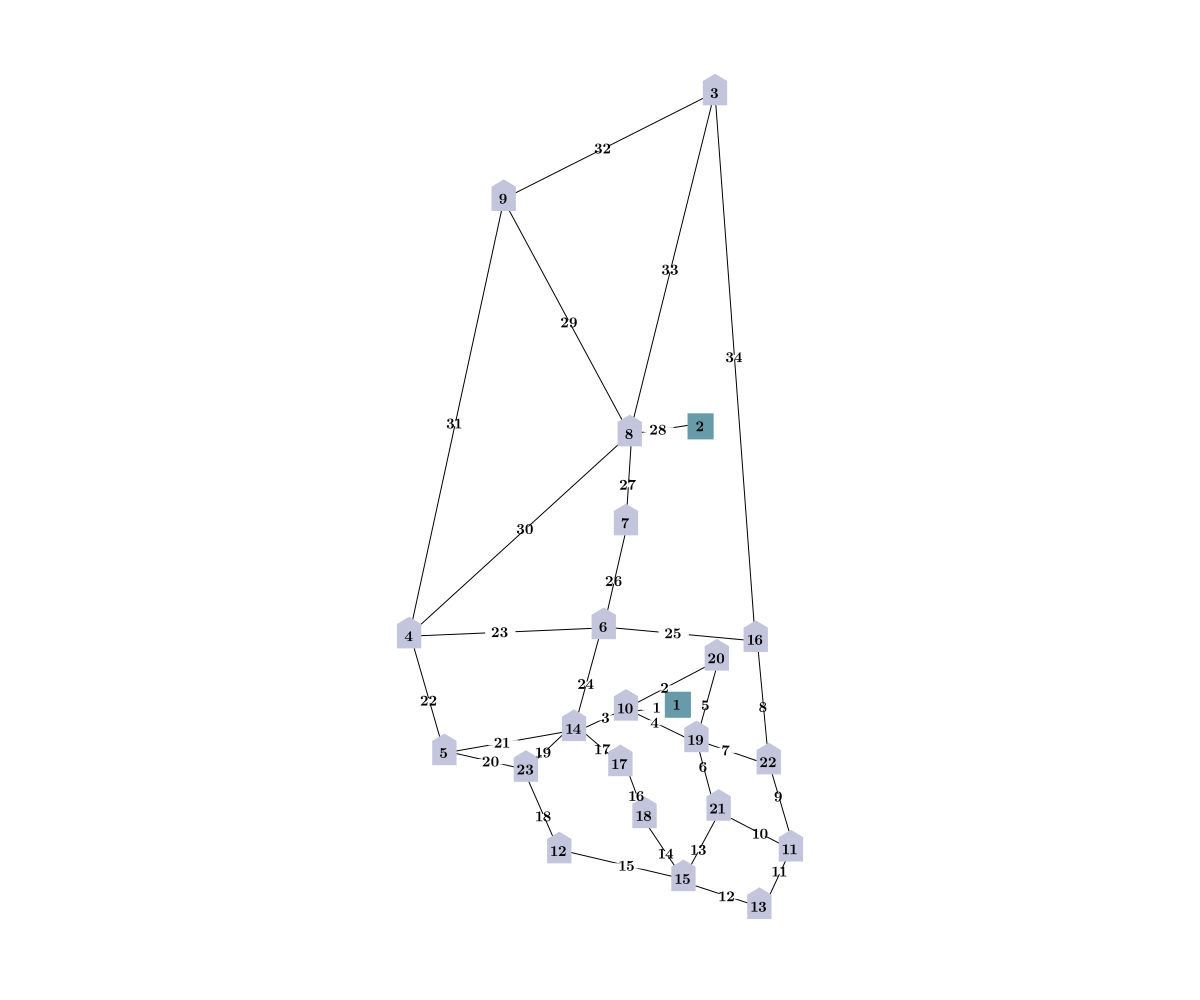

In [16]:
# -- PRINTING THE NETWORK TOPOLOGY --

# Shapes of the nodes of the network 
house_nodeshape(x_i, y_i, s) = 
[
    (x_i + 0.7s * dx, y_i + 0.7s * dy) 
    for (dx, dy) in [(1, 1), (0, 1.6), (-1,1), (-1, -1), (1, -1), (1, 1)]
]

subs_nodeshape(x_i, y_i, s) = [
    (x_i + 0.8s * dx, y_i + 0.8s * dy) 
    for (dx, dy) in [(1, 1), (-1, 1), (-1, -1), (1, -1), (1,1)]
]

node_shapes  = [[subs_nodeshape for _ in Ns];[house_nodeshape for _ in Nu]]

# Definition of the colors of the nodes
colors = ["#689BAA", "#C2C5DB"]

# Creation of the graph representing the network
g = SimpleDiGraph(length(N))
for l in L 
    add_edge!(g, line_ends[l][1], line_ends[l][2])
end

graph = graphplot( adjacency_matrix(g),
                        x               = [ [(n == 1 ? df_bus.x[n] + 0.2 : df_bus.x[n] + 0.5) for n in Ns];
                                            [(n == 20 ? df_bus.x[n]+0.2 : df_bus.x[n]) for n in Nu]],             # x-coordinate of the nodes
                        y               = [(n == 20 ? df_bus.y[n]-0.1 : df_bus.y[n]) for n in N],                                 # y-coordinate of the nodes
                        nodesize        = 0.1,
                        nodestrokewidth = 0,                                        # coutour line width of the node
                        edgestyle       = :solid,
                        nodealpha       = 1,                                        # transparency of node color
                        names           = [((i > Ns_size && i < 10) ? L" \textbf{%$i}" :  L"\textbf{%$i}") for i in N],                        # node label
                        nodeshape       = node_shapes,                              # :circle, :ellipse, :hexagon
                        nodecolor       = colors[[[1 for _ in Ns];[2 for _ in Nu]]],
                        linewidth       = 1,
                        arrow           = false,
                        edgelabel       = Dict((line_ends[l][1], line_ends[l][2]) => (l < 10 ? L" \textbf{%$l} " : L"\textbf{%$l}") for l in L),
                        axis_buffer     = 0.1,
                        fontsize        = 10,
                        size            = (1200, 1000),
                        edgelabel_offset= 0.1,
                        curves          = false,                                    # if an edge is curved or not
                        fmt = :svg
)

display(graph)


[comment]: <> (Subsection)
<p align="left">
    <b style="font-size:1.5vw; color:#c6cde1;">
    2.2 Objective function parameters
    </b>
</p>
<hr style="color:#c6cde1;">

In [28]:
# -- FUNCTIONS FOR COMPUTING THE NPV --

function PV_coeff(tau, lambda)
    return (1 - 1/(1 + tau)^lambda)/tau  
end

# Capital recovery rate formula
# tau: interest rate 
# n : number of annuity received
function CRF(tau, n)
    return (tau * (1 + tau)^n)/((1 + tau)^n - 1)  
end

CRF (generic function with 1 method)

In [29]:
# -- OBJECTIVE FUNCTION PARAMETERS --

nb_years_planning = 1

tau = 0.1

line_loss_factor = 0.35     # phi_l : loss factor of lines
sub_loss_factor  = 0.35     # phi_s : cost per energy lost [€/kWh]

K_l = CRF(tau, 1)           # Capital recovery rate of line constructions
K_s = CRF(tau, 1)           # Capital recovery rate of substation construction or reinforcement

loss_cost = 0.05            # [k$/MWh]
tau_l     = tau             # tau_l : interest rate of circuits
tau_s     = tau             # tau_s : interest rate of substations

f_l = PV_coeff(tau_l, nb_years_planning)
f_s = PV_coeff(tau_s, nb_years_planning)

0.9090909090909094

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    3. Lower-level parameters 
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Load a network model from an Excel file and initialize the parameters of the network;</li>
        <li style="margin-bottom:10px">Define the objective function parameters of the Upper-level</li>
    </ul> 

[comment]: <> (Subsection)
<p align="left">
    <b style="font-size:1.5vw; color:#c6cde1;">
    3.1 Load & PV profiles
    </b>
</p>
<hr style="color:#c6cde1;">

In [30]:
# -- CONSTANT PARAMETERS --

const GRANULARITY = 5       # min
const DAYS_A_YEAR = 365     
const HOURS_PER_YEAR = 8760

8760

In [31]:
# -- FUNCTION THAT NORMALIZES AN ARRAY BY MAX VALUE --

function norm_col(array::Array{Float64}; dims=1)
    return array ./ maximum(array, dims=1)
end

norm_col (generic function with 1 method)

In [32]:
# -- FECTHING THE PROFILE FILES --

PROF_PATH = joinpath(splitdir(@__DIR__)[1], "Manchester_data/LCT_profiles")

SUMMER_PROF_PATH = joinpath(PROF_PATH, "Summer_Load_Profiles.xlsx")
WINTER_PROF_PATH = joinpath(PROF_PATH, "Winter_Load_Profiles.xlsx")
PV_PROF_PATH     = joinpath(PROF_PATH, "Summer_PV_Profiles.xlsx")

"/Users/manoncornet/Documents/University/TFE/DNEP/Manchester_data/LCT_profiles/Summer_PV_Profiles.xlsx"

In [33]:
# data granularity is in minutes
function process_time_steps(nb_time_steps_day::Integer=4; data_granularity::Integer=5)

    nb_min_day = 24 * 60
    max_nb_time_steps = nb_min_day ÷ data_granularity

    @assert nb_time_steps_day < max_nb_time_steps

    time_step_size = nb_min_day ÷ nb_time_steps_day
    nb_agg_time_steps = time_step_size ÷ data_granularity

    return max_nb_time_steps, time_step_size, nb_agg_time_steps 
end

process_time_steps()


(288, 360, 72)

In [37]:
# -- CREATING THE LOAD PROFILES --

# Definition of the simulation time step
agg_period = 24*3 
TIME_STEP_SIZE = GRANULARITY * agg_period
TIME_STEPS = 288 ÷ agg_period
println(TIME_STEPS)
# Assumption: load power factor is constant for all loads and is lagging (inductive)
POWER_FACTOR = 0.9

# Get the max power demand repartition among the nodes in MVA
S_D = convert(Vector{Float64}, df_bus.S_D_mva)[Nu]      # [MVA]
P_D = S_D * POWER_FACTOR                                # [MW]
Q_D = S_D * sin(acos(POWER_FACTOR))                     # [MVar]  

summer_load = build_daily_profiles(SUMMER_PROF_PATH; nb_profiles=Nu_size, period=agg_period)
winter_load = build_daily_profiles(WINTER_PROF_PATH; nb_profiles=Nu_size, period=agg_period)

P_CONSUMPTION = vcat(norm_col(summer_load) .* P_D', norm_col(winter_load) .* P_D')
Q_CONSUMPTION = P_CONSUMPTION * tan(acos(POWER_FACTOR))
S_CONSUMPTION = sqrt.(P_CONSUMPTION.^2 + Q_CONSUMPTION.^2)

println(maximum(Q_CONSUMPTION,dims=1))

4
[0.2789695323866031 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155 0.13948476619330155]


In [38]:
# -- CREATING THE PV PROFILES --
nb_agg_time_steps = 24*3
V_profiles = build_daily_profiles(PV_PROF_PATH; nb_profiles=Nu_size, nb_agg_periods=nb_agg_time_steps)
PV_profiles ./= maximum(PV_profiles, dims=1)   # We suppose the peak in summer is the peak capacity installed

PV_PRODUCTION = zeros(Float64, TOTAL_NB_TIME_STEPS, N_size) # [%] so no unit scaling
PV_SCALES = [1, 0.1] # Scale for each days simulated
for p in 1:NB_SIMULATED_DAYS
    start_time = p + NB_TIME_STEPS_DAY*(p - 1)
    end_time   = start_time + NB_TIME_STEPS_DAY - 1
    PV_PRODUCTION[start_time:end_time, Nu] = PV_profiles * PV_SCALES[i]
end

PV_PRODUCTION



LoadError: UndefVarError: nb_agg_time_steps not defined

[comment]: <> (Subsection)
<p align="left">
    <b style="font-size:1.5vw; color:#c6cde1;">
    3.2 User-related cost
    </b>
</p>
<hr style="color:#c6cde1;">

In [24]:
# -- USER COSTS IN k€ --

GENSET_COST     = 200     # k€/MVA
FUEL_COST       = 0.5     # k€/MWh of electricity produced (embeds the conversion)
CONVERTER_COST  = 200     # k€/MVA converter installation
PV_COST         = 50      # k€/MWc PV installation

IMP_ELECTRICITY_ENRG_COST   = 0.3   # k€/MWh, cost of electricity bought to retailer
IMP_ELECTRICITY_DSO_COST    = 0.15  # k€/MWh, cost of electricity imported from DS
EXP_ELECTRICITY_ENRG_COST   = 0.15  # k€/MWh, cost of electricity injected in DS
EXP_ELECTRICITY_DSO_COST    = 0.15  # k€/MWh, cost of electricity injected in DS
GRID_CONNECTION_COST        = 300   # k€/MVA_year

300

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 28467 rows, 21639 columns and 79242 nonzeros
Model fingerprint: 0x0b707496
Model has 288 quadratic constraints
Variable types: 8513 continuous, 13126 integer (6870 binary)
Coefficient statistics:
  Matrix range     [1e-09, 2e+04]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [8e-03, 1e+03]
  Bounds range     [8e-01, 1e+00]
  RHS range        [1e-03, 2e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 4778 rows and

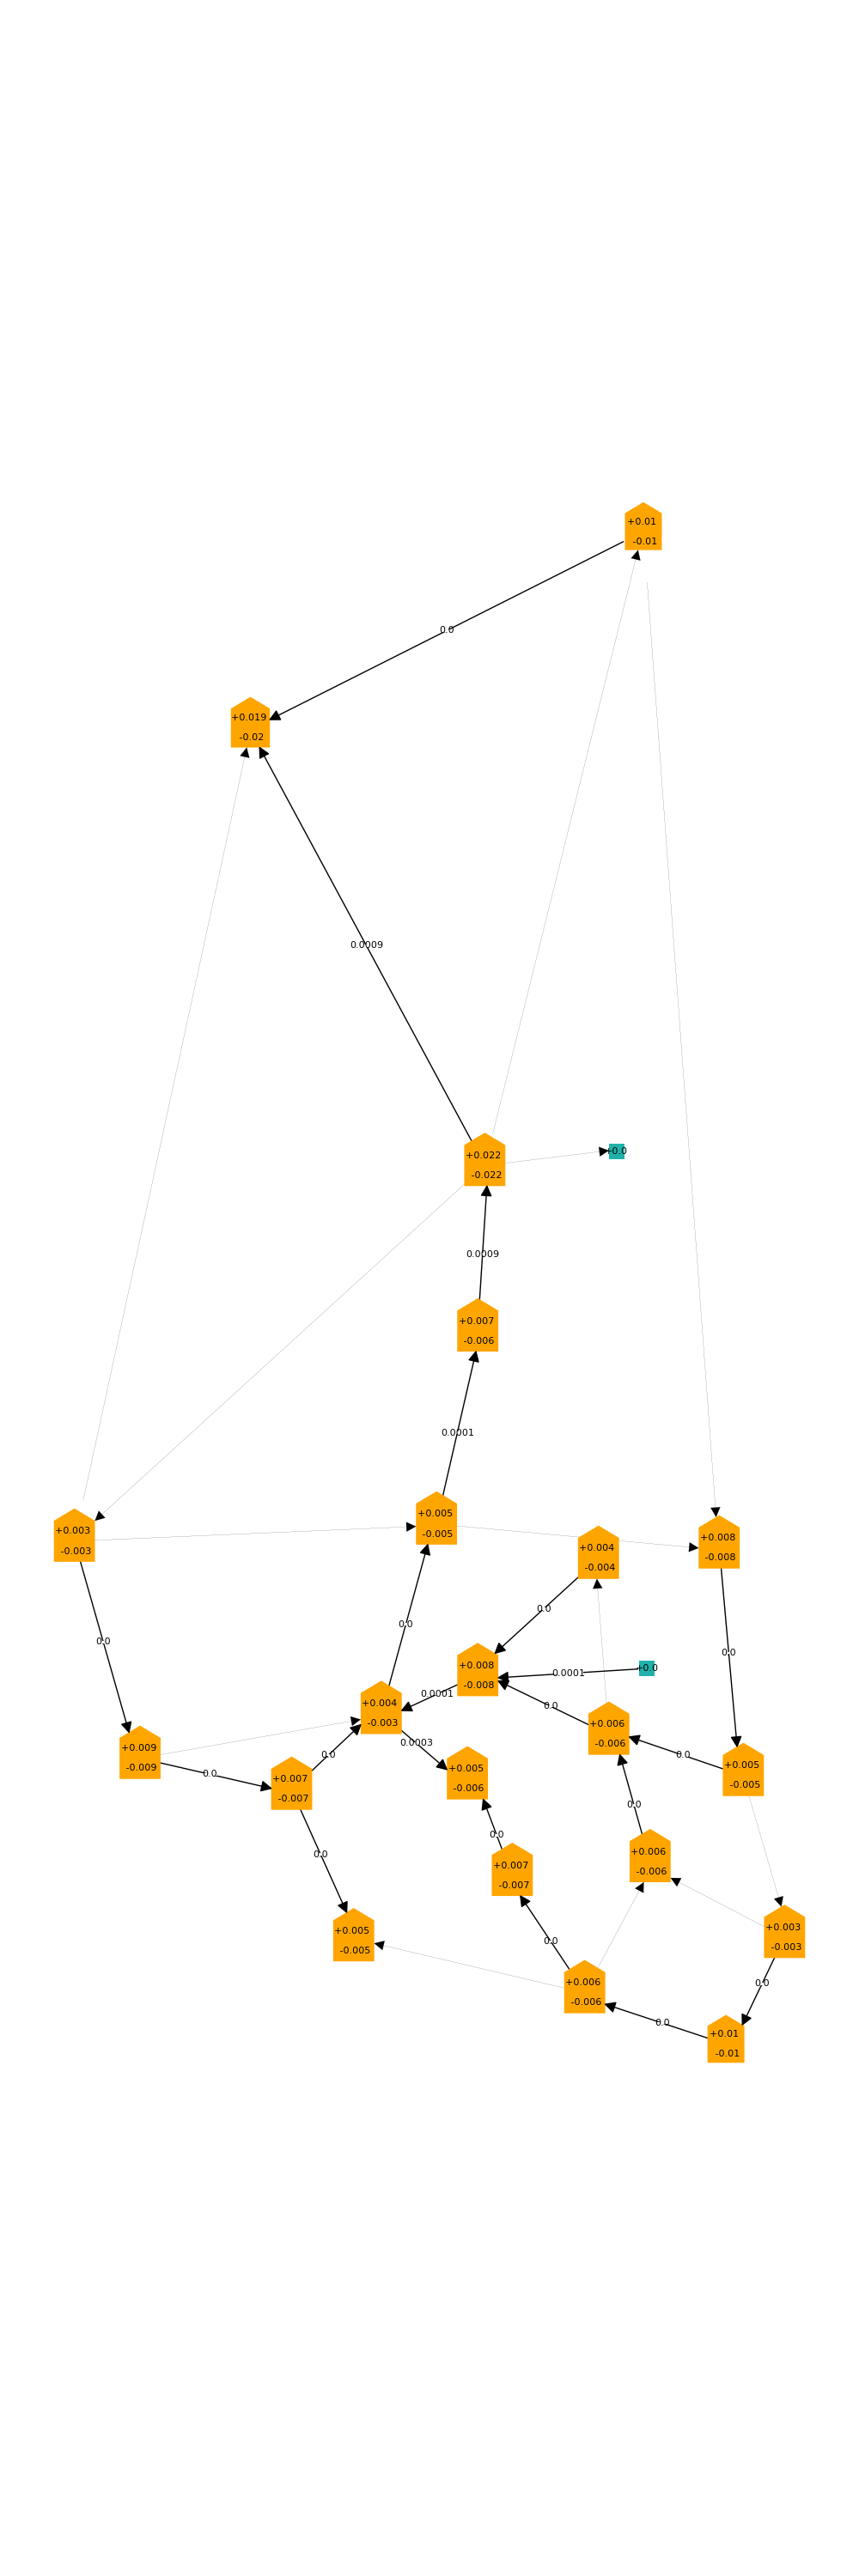

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [27]:
radiality = true
include("bilevel_BFM_1P.jl")